# 讀書會作業 2  
本次作業以「陳柏惟罷免案」為主，從PTT的八卦版與政黑版中抓2021/09/15-2021/10/25的資料。從這次資料中，首先，我們主要先斷詞，在進行CKIP之分析，確認本次主題的討論重點為何，再利用SnowNLP進行第一次的情緒分析。接著，我們進行ngram、TF-IDF的分析，從資料中尋找熱門字頻的相關議題。最後，我們進行文件分類，建立Model以訓練預測結果。

## 大綱
1. 套件說明
2. 資料處理
    + 2.1 資料匯入
    + 2.2 資料清理
    + 2.3 文章斷詞
3. CKIP 自然語言處理
    + 3.1 CKIP安裝
    + 3.2 將抓取結果用coreNLP進行處理
    + 3.3 探索分析 - NER 
    + 3.4 探索分析 - POS
4. 利用SnowNLP進行情緒分析 
    + 4.1 PPT不同"版"情緒時間趨勢
    + 4.2 正面詞彙探索
    + 4.3 負面詞彙探索
    + 4.4 CKIP小結論
5. TF-IDF + Ngram 
    + 5.1 TF-IDF
    + 5.2 透過結巴斷詞與N-gram幫助建立字典
    + 5.3 建立Ngram預測模型
    + 5.4 Bigram 視覺化
6. 文件分類
    + 6.1文字前處理
    + 6.2 資料集基本檢視
    + 6.3 將資料切成訓練集與測試集
    + 6.4 將文章轉為 DTM
    + 6.5 比較不同模型和資料組合的訓練結果

In [4]:
%pwd #顯示當前路徑

'/Users/yuxiulin/Anaconda/HW2_Harper'

# 1. 套件說明

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [99]:
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

# 2. 資料處理

## 2.1 資料前處理
先將資料匯入，並在用關鍵字篩出更符合我們主題的文章。

In [100]:
fighting = pd.read_csv("QQQ_articleMetaData.csv") #匯資料
fighting.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,1.轉錄網址︰\nhttps://www.facebook.com/wanyu.claire...
1,Re:[討論]如果張亞中上了，民眾黨是最大得利者嗎？,2021/09/15,03:29:16,https://www.ptt.cc/bbs/HatePolitics/M.16316765...,hong888,HatePolitics,26,7,2,張亞中之亂，\n是1450透過網路灌票、反串韓粉留言，引誘黨內反朱勢力搭便車，\n共同製造的...
2,[新聞]朱立倫拉張善政合體朱：當選主席韓一定,2021/09/15,03:33:10,https://www.ptt.cc/bbs/HatePolitics/M.16316767...,WeiKitten,HatePolitics,57,25,4,chinatimes\nhttps://www.chinatimes.com/realtim...


In [101]:
# 看看有幾篇文章
print(f"number of posts: {fighting.shape[0]}")

number of posts: 7009


In [102]:
# 再篩一次文章
keywords = ['陳柏惟','罷免','刪Q','楊文元','顏寬恒','3Q']
toMatch = '|'.join(keywords)

In [103]:
fighting = fighting.loc[fighting['sentence'].str.contains(toMatch) | fighting['artTitle'].str.contains(toMatch), :]
fighting.reset_index(inplace=True, drop=True) #重設index
print(fighting.shape)

(6094, 10)


## 2.2 資料清理  
進行CKIP分析前，先對`QQQ_articleMetaData.csv`檔案進行清理。
- 去除NA值
- 正規化資料清理
- 去除不是中文的字詞

In [104]:
# 移除sentence為na值的資料
fighting.dropna(subset = ["sentence"], inplace=True)

In [105]:
#移除PTT貼新聞時會出現的格式用字
fighting['sentence'] = fighting.sentence.apply(lambda x: re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
fighting['sentence'] = fighting.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))

In [106]:
def clean(row):  
    result = re.sub('[\t]{2,}', '', row)
    result = re.sub('#_*', '', result)
    result = re.sub('\\n', '', result)
    result = re.sub('\s{2,}', '', result)
    result = re.sub('(http|https)://.*', '', result)
    result = re.sub('(新聞|新聞來源|網址|網址媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除|新聞網址|新聞內容|附註|心得|來源)', '',result)
    result = re.sub('(http|https)://.*', '', result)
    return result

In [107]:
fighting['sentence'] = fighting.sentence.apply(clean)
fighting.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[討論]加州州長罷免失敗,2021/09/15,03:52:34,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,followwind,HatePolitics,137,28,2,這笑話一般的罷免結果可想而知就是個笑話：加州共和黨洗洗睡吧。先不說加州本來就是大藍州，這次選...
1,[討論]蔡詩萍》當我的藍營友人，在憂心「張亞,2021/09/15,04:11:29,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,Qchild,HatePolitics,89,49,4,蔡詩萍》當我的藍營友人，在憂心「張亞中現象」時！【愛傳媒蔡詩萍專欄】有些藍營的朋友很憂心，搞...
2,[討論]建議把3Q留在立法院當提款機,2021/09/15,05:31:06,https://www.ptt.cc/bbs/HatePolitics/M.16316838...,godroid,HatePolitics,13,5,0,王浩宇真的被罷免了少了一台提款機所以在野黨聲勢始終爬不起來建議陳柏惟這台提款機將他留在立法院...


## 2.3 文章斷詞  
中文文集我們使用jieba套件進行斷詞與移除停用字

In [108]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/3Q_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/yuxiulin/Anaconda/HW2_Harper/dict/dict.txt.big ...
Loading model from cache /var/folders/3r/4qy4xw351fv_qsw13dtgzht00000gn/T/jieba.ud4c3196ed084218006f84a9e59283eb5.cache
Loading model cost 1.445 seconds.
Prefix dict has been built successfully.


In [109]:
def getToken(row):    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [110]:
fighting['word'] = fighting.sentence.apply(getToken)
# 將word欄位展開
fighting_token = fighting.explode('word') 
fighting_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[討論]加州州長罷免失敗,2021/09/15,03:52:34,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,followwind,HatePolitics,137,28,2,這笑話一般的罷免結果可想而知就是個笑話：加州共和黨洗洗睡吧。先不說加州本來就是大藍州，這次選...,笑話
0,[討論]加州州長罷免失敗,2021/09/15,03:52:34,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,followwind,HatePolitics,137,28,2,這笑話一般的罷免結果可想而知就是個笑話：加州共和黨洗洗睡吧。先不說加州本來就是大藍州，這次選...,罷免
0,[討論]加州州長罷免失敗,2021/09/15,03:52:34,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,followwind,HatePolitics,137,28,2,這笑話一般的罷免結果可想而知就是個笑話：加州共和黨洗洗睡吧。先不說加州本來就是大藍州，這次選...,可想而知


In [111]:
#轉換日期格式
fighting['artDate'] = pd.to_datetime(fighting['artDate'], format="%Y/%m/%d")

In [112]:
#計算每天不同字的詞頻
word_count = fighting_token.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

,artDate,word,size
138303,2021/10/23,罷免,2330
141106,2021/10/23,陳柏惟,965
148435,2021/10/24,罷免,912
137806,2021/10/23,立委,684
131337,2021/10/23,同意,679
127778,2021/10/23,3Q,636
136101,2021/10/23,民進黨,615
43895,2021/10/06,陳柏惟,606
131216,2021/10/23,台灣,580
134213,2021/10/23,投票,552


# 3.CKIP 自然語言處理
## 3.1 CKIP安裝

In [113]:
pip install keras==2.6.*

zsh:1: no matches found: keras==2.6.*
Note: you may need to restart the kernel to use updated packages.


In [114]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Users/yuxiulin/opt/anaconda3/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/yuxiulin/opt/anaconda3/lib/python3.8/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
/Users/yuxiulin/opt/anaconda3/lib/python3.8/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
/Users/yuxiulin/opt/anaconda3/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.n

## 3.2 將抓取結果用coreNLP進行處理

### 3.2.1 定義文字清理的相關function

In [115]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

### 3.2.2 CKIP 設定  
讀入自定義且與主題相關的辭典

In [116]:
# 自定義辭典
with open('./dict/3Q_dict.txt',encoding = 'UTF-8') as f:
    lines = f.read().splitlines()
dict_3Q = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_3Q)
print(dictionary2)

[(2, {'3Q': 1.0, '刪Q': 1.0, '罷免': 1.0, '台獨': 1.0, '統獨': 1.0, '正義': 1.0, '反韓': 1.0, '顏家': 1.0, '陳菊': 1.0, '萊豬': 1.0, '中共': 1.0, '綠黨': 1.0}), (3, {'陳柏惟': 1.0, '罷免案': 1.0, '在野黨': 1.0, '顏家班': 1.0, '顏清標': 1.0, '顏寬恒': 1.0, '基進黨': 1.0, '懶人包': 1.0, '內交部': 1.0, '抽海砂': 1.0, '打手槍': 1.0, '公投案': 1.0, '假公民': 1.0, '黑歷史': 1.0, '烏賊戰': 1.0, '反惡罷': 1.0, '0提案': 1.0, '江啟臣': 1.0, '朱立倫': 1.0, '翻桌子': 1.0}), (4, {'刪Q總部': 1.0, '立法委員': 1.0, '獨派立委': 1.0, '台灣基進': 1.0, '反顏家班': 1.0, '我沒有輸': 1.0, '疲勞駕駛': 1.0, '快打旋風': 1.0, '賭博機台': 1.0, '肇事逃逸': 1.0, '藍綠對決': 1.0, '3零立委': 1.0, '時代力量': 1.0}), (5, {'台灣基進黨': 1.0, '顏寬恒地標': 1.0, '公投反萊豬': 1.0, '罷免割萊委': 1.0, '潛艦伏擊區': 1.0, '罷免提議書': 1.0, '假公民團體': 1.0, '城市肉搏戰': 1.0, '民主進步黨': 1.0, '中國國民黨': 1.0, '台灣民眾黨': 1.0, '自由臺灣黨': 1.0, '峰鹿大烏龍': 1.0}), (7, {'立法委員罷免案': 1.0}), (8, {'台中市第二選舉區': 1.0})]


In [117]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(fighting):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in fighting.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['artUrl'],sentence])            
            temp_tokens = get_pos(row['artUrl'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['artUrl'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]  

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['artUrl','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['artUrl','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['artUrl','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [118]:
# pos_table, entity_table, sentence_table = get_nlp_result(fighting)

該部分由組員分工，故直接匯入他的csv檔案，進行後續分析。

In [142]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("pos_table_3Q.csv") 
entity_table = pd.read_csv("entity_table_3Q.csv") 
sentence_table = pd.read_csv("sentence_table_3Q.csv") 

In [143]:
pos_table.head(5) # word pos 列表

,artUrl,word,pos
0,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,這,Nep
1,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,笑話,Na
2,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,一般,A
3,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,的,DE
4,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,罷免,VC


In [144]:
entity_table.head(5) # word entity 列表

,artUrl,word,ner
0,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,加州,GPE
1,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,共和黨,NORP
2,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,加州,GPE
3,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,大藍州,GPE
4,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,共和黨,NORP


In [145]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['artUrl'].unique())}") # 600篇文
print(f"posts have NER: {len(entity_table['artUrl'].unique())}") # 591篇有抓到ner

total posts numbers: 6092
posts have NER: 5780


# 3.3 探索分析 - NER  
將剛才分析的資料匯入

## 3.3.1 NER 種類分析
查看標註這個文集後辨識出哪些實體種類

In [146]:
entity_table['ner'].unique()

array(['GPE', 'NORP', 'PERSON', 'ORG', 'CARDINAL', 'DATE', 'ORDINAL',
       'LOC', 'TIME', 'FAC', 'PERCENT', 'LANGUAGE', 'WORK_OF_ART',
       'EVENT', 'MONEY', 'LAW', 'QUANTITY', 'PRODUCT'], dtype=object)

In [147]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
13,PERSON,29582
11,ORG,14248
4,GPE,11844
1,DATE,6204
0,CARDINAL,5470
9,NORP,2102
5,LANGUAGE,1738
10,ORDINAL,1658
16,TIME,1407
3,FAC,689


<ipython-input-148-8776bebda193>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


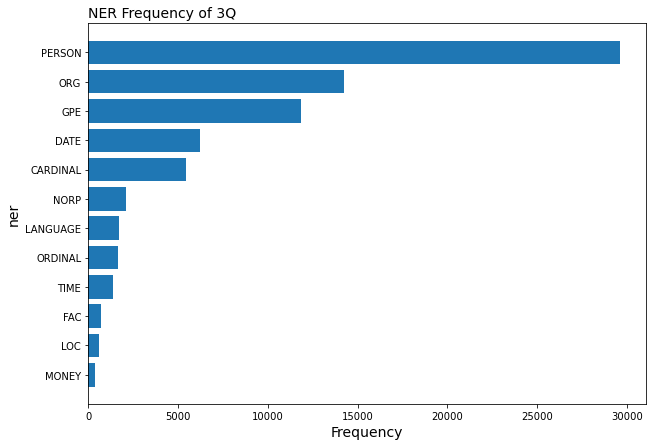

In [148]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of 3Q',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

## 3.3.2 涉及到的人名(PERSON)

<ipython-input-149-ad4914e59a1b>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


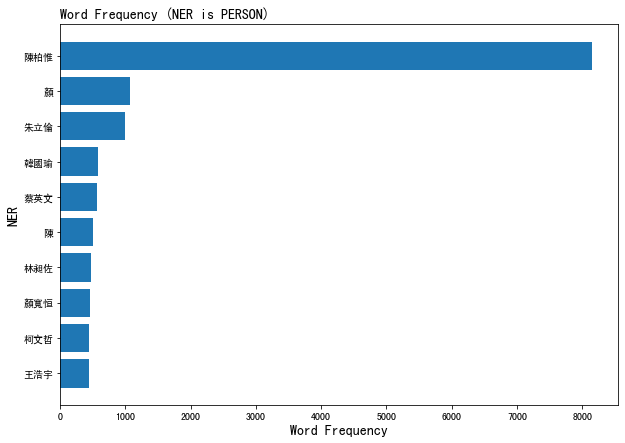

In [149]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif']=['SimHei']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

在本次結果中，陳柏惟果真是該主題最熱門的討論人物，而在「朱立倫」、「韓國瑜」、「蔡英文」、「林昶佐」、「顏寬恒」也都有一定程度的討論。

看一下含特定關鍵字的貼文內容

In [150]:
keyword_list = ['陳柏惟','顏家']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

陳柏惟 顏家：6466篇相關貼文


,artUrl,sentence
41,https://www.ptt.cc/bbs/HatePolitics/M.16316838...,王浩宇真的被罷免了少了一台提款機所以在野黨聲勢始終爬不起來建議陳柏惟這台提款機將他留在立法院...
43,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,王浩宇黃捷陳柏惟/知道不知道請問您會不會參與罷免的連署
44,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,黃捷陳柏惟/會不一定不會拒答如果罷免的提案通過，舉行罷免的投票，不論您同不同意罷免，請問您會...
45,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,韓國瑜│王浩宇黃捷陳柏惟//│//一定會│可能會│不一定│不會│如果舉行罷免的投票，假如明天...
46,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,韓國瑜│王浩宇黃捷陳柏惟///│//滿意│不滿意│沒意見│/就任百日請問您喜不喜歡
47,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,韓國瑜│王浩宇黃捷陳柏惟////│//喜歡│不喜歡│不認識│沒意見│資料韓國瑜//////王...
62,https://www.ptt.cc/bbs/HatePolitics/M.16317059...,惡意罷免陳柏惟案如果通過一定會趁著超高人氣的態勢直攻明年台中市長再次創造奇蹟完成不可能的任務...
70,https://www.ptt.cc/bbs/HatePolitics/M.16317075...,反而可能幫助陳柏惟收編地方社團，削弱顏家的勢力
71,https://www.ptt.cc/bbs/HatePolitics/M.16317075...,我的看法是陳柏惟不會倒，反而顏家會一蹶不振
75,https://www.ptt.cc/bbs/HatePolitics/M.16317075...,這就是顏家女兒要修練的功德糧，消業障


在貼文中，除了討論罷免案之外，仍有許多人在討論陳柏惟與顏家之間的關係。

## 3.3.3 涉及到的組織(ORG)

<ipython-input-151-3964b9f010f8>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


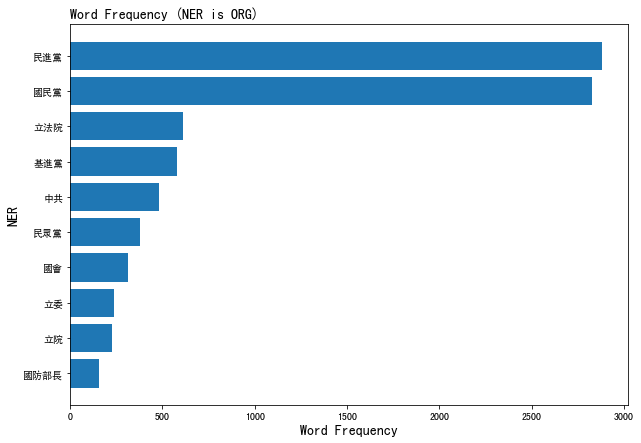

In [151]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif']=['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

在本次結果中，民進黨是該主題最熱門的討論組織，而「國民黨」、「立法院」、「基進黨」、「中共」、「民眾黨」也都有一定程度的討論。

In [152]:
keyword_list = ['民進黨','國民黨','立法院']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(5)

民進黨 國民黨 立法院：4421篇相關貼文


,artUrl,sentence
7,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,愛傳媒蔡詩萍專欄有些藍營的朋友很憂心，搞不好張亞中會贏得國民黨主席呢
9,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,但，我必須說，如果月日的結果，真是張亞中出線，那也是國民黨該有的命運，何該是國民黨要走向激化...
10,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,從近一點的視角觀察，從洪秀柱當上黨主席，到換柱風波不過是把國民黨內兩條路線，兩種國家認知的糾...
15,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,二則，他們把癥結推給國民黨內，本土藍的作梗，知識藍的高傲，認為國民黨要往更純粹的方向重建
16,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,三呢，國民黨的黨員結構，促成了這種意識高漲的假象，深藍也可以掌握黨中央，然後掃除跟著綠營屁股...


在貼文中，網友也從立法委員本身討論到相關所屬的政黨，討論話題仍圍繞在陳柏惟和顏加所屬的激進黨與國民黨。

## 3.3.4 涉及到的民族、宗教、政治團體(NORP)

<ipython-input-153-21a90926e7ac>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


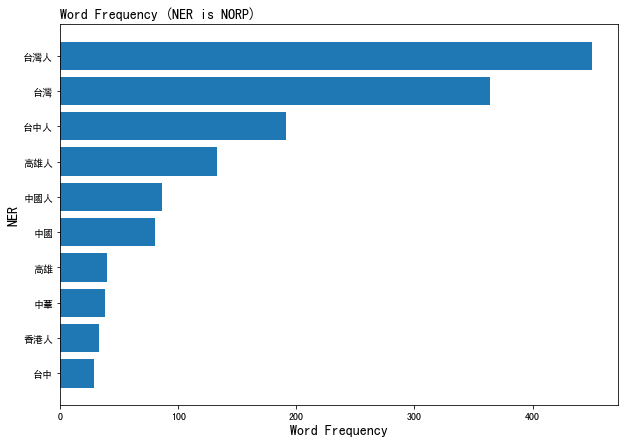

In [153]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif']=['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

在本次結果中，台灣人（包含台中與高雄）、台灣是該主題最熱門的討論話題，本次結果中出現「高雄」與本次罷免地點（台中）看似無關，但我們認為高雄曾發生過市長罷免案，因此網友可能拿之作為比較。

In [154]:
keyword_list = ['台灣人','台灣','台中人']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(5)

台灣人 台灣 台中人：3657篇相關貼文


,artUrl,sentence
27,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,但，我懂選舉，我長期觀察民意，韓國瑜除了深藍為他瘋狂外，韓真的有觸碰到台灣社會不少底層的民怨...
29,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,然而，大選的形勢，依舊在誰更愛台灣的主軸下，碾壓了國民黨，碾壓了韓國瑜
30,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,我看不出，未來的幾年，這捍衛台灣的主旋律，能有多大的改變
32,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,深藍主導的國民黨，統派意識的黨主席，在背離台灣主流選民的逆勢操作下，除非他是神，否則，他也只...
34,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,民進黨已經相當成功的，把深綠淺綠整合起來，唯獨藍營，中國藍與台灣藍仍在彼此糾葛


在貼文中，可以看到網友將高雄罷韓拿來與本次主題比較。

## 3.4 探索分析 - POS

### 3.4.1 POS 種類分析
查看辨識出哪幾種POS，種類如下表示：
- POS 詞性列表:
  - 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
  - Na: 普通名詞
  - D: 副詞
  - VC: 動作及物動詞
  - Nb: 專有名詞
  - FW: 外文
  - VH: 狀態不及物動詞
  - Nh: 代名詞
  - DE: 的之得地
  - P: 介詞
  - VA: 動作不及物動詞
  - T: 語助詞
  - SHI: 是

In [155]:
pos_table['pos'].unique()

array(['Nep', 'Na', 'A', 'DE', 'VC', 'Dk', 'D', 'SHI', 'Nf', 'Nc', 'Nb',
       'VA', 'T', 'VE', 'COMMACATEGORY', 'Neu', 'P', 'Ncd', 'Cbb', 'VF',
       'I', 'VHC', 'VH', 'VJ', 'Neqa', 'Nh', 'Di', 'VG', 'Ng', 'VL',
       'Dfa', 'V_2', 'Nes', 'VCL', 'Dfb', 'Da', 'VAC', 'Nd', 'VK', 'VD',
       'Nv', 'Caa', 'FW', 'VB', 'COLONCATEGORY', 'Neqb', 'Cab', 'VI',
       'Cba', 'PERIODCATEGORY', 'DASHCATEGORY', 'PARENTHESISCATEGORY',
       'DM', 'DOTCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [156]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
17,Na,162171
5,D,111788
37,VC,74234
43,VH,49064
18,Nb,41953
7,DE,39446
31,P,35686
19,Nc,33816
29,Nh,29711
40,VE,28689


<ipython-input-157-58472d1a927e>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


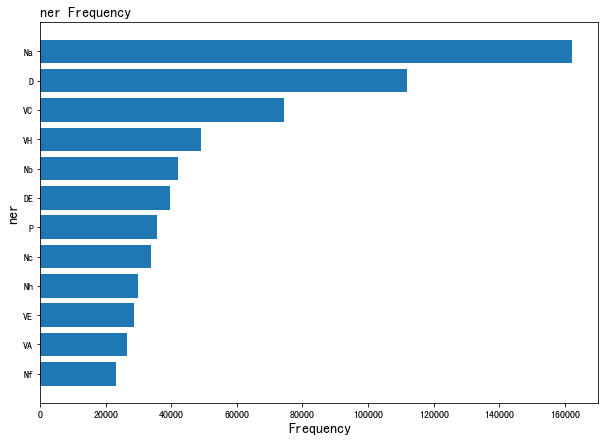

In [157]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

## 3.4.2 涉及到的名詞(Na)  
 - 我們可以找出談論3Q罷免案時大部分討論到的專有名詞，探索大家的關注焦點。
 - 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [158]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,陳柏惟,8183
1,民進黨,2918
2,國民黨,2835
3,朱立倫,1006
4,基進黨,606
5,韓國瑜,580
6,蔡英文,568
7,台灣基進,541
8,陳,511
9,中共,502


<ipython-input-159-f1a7b0d10412>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


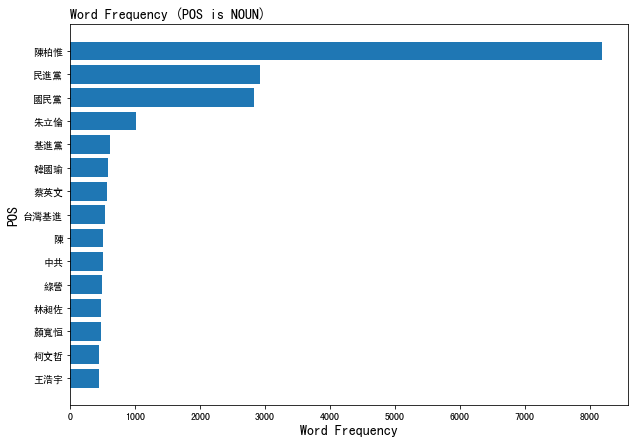

In [159]:
# 設定中文字形
plt.rcParams['font.sans-serif']=['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到3Q罷免案中，「民進黨」及「國民黨」也是討論度很高的相關詞彙，其餘包括「朱立倫」、「基進黨」和「韓國瑜」也是很熱門關鍵字。

## 3.4.3 涉及到的動詞(VERB)

我們可以找出談論3Q罷免案時大部分討論到的動詞，探索提到該罷免案時的相關行為。
 - VC: 動作及物動詞  
 - VH: 狀態不及物動詞  
 - VA: 動作不及物動詞

In [160]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

,word,count
4252,這樣,1659
1976,成功,916
17,一樣,716
3184,直接,533
3954,認真,371
4397,重要,362
130,不同,331
691,努力,316
1282,失敗,277
3393,簡單,264


<ipython-input-161-7f2fc0362aab>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


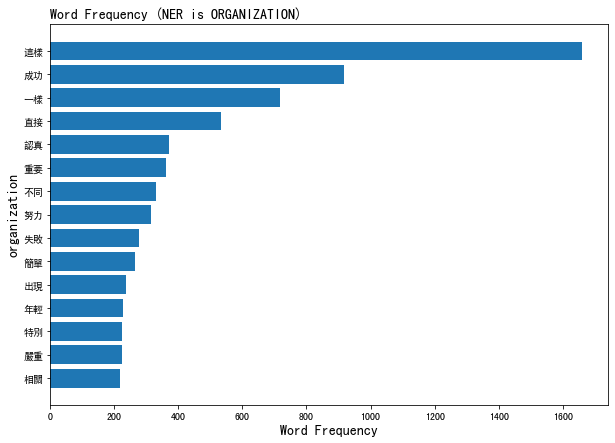

In [161]:
plt.rcParams['font.sans-serif']=['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

發現在貼文中的動詞，「成功」佔了相當高的頻率，其他還有出現「認真」、「努力」等詞彙，推測鄉民們可能是在討論有關陳柏惟成功被被罷免的相關議題。

In [162]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['成功','認真','努力']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

成功 認真 努力：1467篇相關貼文


,artUrl,sentence
34,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,民進黨已經相當成功的，把深綠淺綠整合起來，唯獨藍營，中國藍與台灣藍仍在彼此糾葛
103,https://www.ptt.cc/bbs/HatePolitics/M.16317506...,中常會後民進黨也明確表達立場，肯定陳柏惟問政認真，將全力支持他留在立法院，此外民進黨名台中區...
107,https://www.ptt.cc/bbs/HatePolitics/M.16317506...,而會後發言人謝佩芬更明確表達立場，民進黨不但會保持關心，也會全力支持問政認真的立委，同時呼籲...
109,https://www.ptt.cc/bbs/HatePolitics/M.16317506...,蔡其昌說，陳柏惟是自己看過的政治新手中，少見令人感動的年輕人，或許沒有龐大的地方組織支撐，但...
110,https://www.ptt.cc/bbs/HatePolitics/M.16317506...,何欣純表示，很常與陳柏惟在國會打招呼，下午在地方上又碰頭，這一年多來，國會審法案審預算陳柏惟...
111,https://www.ptt.cc/bbs/HatePolitics/M.16317506...,黃國書也提到，陳柏惟是一個在中央和地方都認真打拼的傑出立委，多個日子以來在中央質詢從不缺席，...
168,https://www.ptt.cc/bbs/HatePolitics/M.16317743...,然後就扛過罷韓事件，罷佛地魔成功，眼看之後罷也要成功，民進黨要扛缺電缺疫苗危機之前還有缺水國...
216,https://www.ptt.cc/bbs/HatePolitics/M.16318426...,就是這樣才笑死人從去年中就開始這樣了，結果現實的民調跟網路風向完全相反，之前黃捷罷免案，看這...
263,https://www.ptt.cc/bbs/HatePolitics/M.16319504...,想法︰我們先來回想一件事，在江啟臣主席補選替補了白海豚的任期緊接而來要讓國民黨馬上崛起，要開...
266,https://www.ptt.cc/bbs/HatePolitics/M.16319655...,根據鐘小平市議員的報告罷免林昶佐的二階連署已經有萬多份差千就達標了罷免，公投成功，接下來就是...


# 4. 利用SnowNLP進行情緒分析  
 - SnowNLP 針對中文設計，可以提取句子的情緒分類
 - 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
 - 情緒值在 0~1之間，代表負面到正面

將句子和日期合併，方便之後做分析

In [163]:
sentence_table = pd.read_csv("sentence_table_3Q.csv") #匯資料
MetaData = pd.read_csv('QQQ_articleMetaData.csv', encoding='UTF-8') #匯資料

sentiment_date = pd.merge(sentence_table, MetaData[['artUrl','artDate','artCat']],on='artUrl',how='left')
sentiment_date.head(3)

,artUrl,sentence,artDate,artCat
0,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,這笑話一般的罷免結果可想而知就是個笑話加州共和黨洗洗睡吧,2021/09/15,HatePolitics
1,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,先不說加州本來就是大藍州，這次選舉幾個共和黨候選人的戰略竟然不是往中間走而是繼續走川普的保守...,2021/09/15,HatePolitics
2,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,真他媽笑死人,2021/09/15,HatePolitics


In [167]:
from snownlp import SnowNLP
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

,artUrl,sentence,artDate,artCat,sentimentValue
0,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,這笑話一般的罷免結果可想而知就是個笑話加州共和黨洗洗睡吧,2021/09/15,HatePolitics,0.000660
1,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,先不說加州本來就是大藍州，這次選舉幾個共和黨候選人的戰略竟然不是往中間走而是繼續走川普的保守...,2021/09/15,HatePolitics,0.004255
2,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,真他媽笑死人,2021/09/15,HatePolitics,0.262633
3,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,再爛都遠勝加州共和黨檯面上這些垃圾,2021/09/15,HatePolitics,0.033745
4,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,阿諾那種共和黨人在共和黨內已經被邊緣化了,2021/09/15,HatePolitics,0.095808


In [168]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() # 2145句話

count    28208.000000
mean         0.356641
std          0.378919
min          0.000000
25%          0.006540
50%          0.184270
75%          0.724947
max          1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

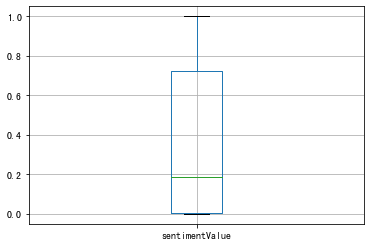

In [169]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每天的情緒分數取平均，並轉換時間格式為天

In [170]:
sentiment_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.date
sentiment_count = sentiment_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2021-09-14,0.414707
1,2021-09-15,0.397446
2,2021-09-16,0.379365
3,2021-09-17,0.285205
4,2021-09-18,0.351902
5,2021-09-19,0.381055
6,2021-09-20,0.388600
7,2021-09-21,0.369189
8,2021-09-22,0.480403
9,2021-09-23,0.374692


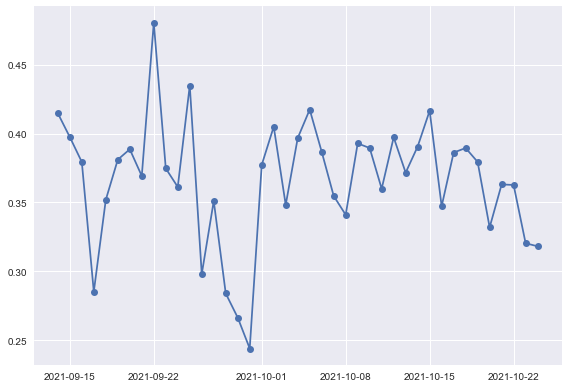

In [171]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

從上圖我們可以發現大部分天數的情緒值落在0.35-0.4之間，綜觀整個期間幾乎都是負面情緒，可能因為是罷免相關的主題而造成此結果。但9/22的情緒分數特別高，因此後面將會特別挑出來分析。

## 4.1 PPT不同"版"情緒時間趨勢

In [172]:
# 篩出安卓和蘋果的用戶
sentiment_date = sentiment_date[sentiment_date['artCat'].isin(['Gossiping','HatePolitics'])]
# 算每天的情緒
source_count = sentiment_date.groupby(['artDate','artCat'])['sentimentValue'].mean().reset_index()
source_count.head(10)

,artDate,artCat,sentimentValue
0,2021-09-14,Gossiping,0.414707
1,2021-09-15,Gossiping,0.423302
2,2021-09-15,HatePolitics,0.387307
3,2021-09-16,Gossiping,0.393103
4,2021-09-16,HatePolitics,0.372135
5,2021-09-17,Gossiping,0.260547
6,2021-09-17,HatePolitics,0.482467
7,2021-09-18,Gossiping,0.413387
8,2021-09-18,HatePolitics,0.255455
9,2021-09-19,Gossiping,0.449483


In [173]:
# spread the column
source_pivot = source_count.pivot_table(index=['artDate'],columns='artCat',values='sentimentValue',fill_value=0).reset_index()
source_pivot

artCat,artDate,Gossiping,HatePolitics
0,2021-09-14,0.414707,0.000000
1,2021-09-15,0.423302,0.387307
2,2021-09-16,0.393103,0.372135
3,2021-09-17,0.260547,0.482467
4,2021-09-18,0.413387,0.255455
5,2021-09-19,0.449483,0.336313
6,2021-09-20,0.281184,0.581948
7,2021-09-21,0.349810,0.390015
8,2021-09-22,0.286510,0.523490
9,2021-09-23,0.434008,0.291109


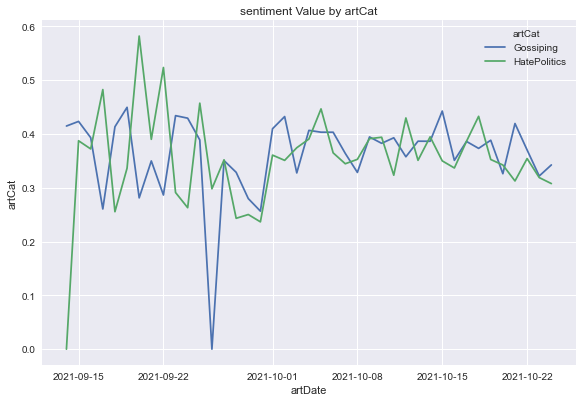

In [174]:
# 不同裝置情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="artDate", y=["Gossiping", "HatePolitics"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('artCat')
plt.title('sentiment Value by artCat')

plt.show()

從上圖中發現無論是在「八卦版」或是「政黑板」大部分天數的情緒值都在0.5以下，嚴重偏向負面(原因可能因為主題為罷免相關議題)。但是9/17-9/22號的分數特別高，因此後面會特別挑出來分析。

## 4.2 正面詞彙探索

從上圖中可以發現 9/17-9/22 的情緒特別高，我們將這幾天的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值偏低，情緒值高於0.6的句子不多(情緒值選0.55以上的句子)

In [175]:
# 篩時間區間
startdate = pd.to_datetime("2021-09-17").date()
enddate = pd.to_datetime("2021-09-22").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.55]

# 看一下正面句子都在討論甚麼
filter_sentiment.head(10)

,artUrl,sentence,artDate,artCat,sentimentValue
218,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,就像向吳斯懷陳情請求政府譴責香港暴政，向陳柏惟陳情要求開打柯興疫苗一樣，人家會轉你的陳情單就有鬼了,2021-09-17,HatePolitics,0.875562
221,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,蔡其昌民進黨已宣布力挺陳柏惟全力支持反罷免記者何宗翰台中報導立委陳柏惟罷免投票倒數，立法院長...,2021-09-17,HatePolitics,0.999923
222,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,蔡其昌說，罷免是正常的民主制度的一環，但罷免要有正當性，從陳柏惟當選到現在，地方需要解決什麼...,2021-09-17,HatePolitics,0.998273
223,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,陳在立院的質詢也備受專業監督單位的肯定，不知道有什麼理由要罷免這樣的立委，若只靠一些片段抹黑...,2021-09-17,HatePolitics,0.648200
226,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,反罷免最好的方法就是正面宣傳,2021-09-17,HatePolitics,0.857737
227,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,陳柏惟說，台灣民主化後，並沒有做深刻的教育，有必要把立委職權該做的事情說清楚,2021-09-17,HatePolitics,0.974516
228,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,關於選舉民調的部分，陳柏惟說，他認為民調就像股票的技術分析，他相信基本面更重要,2021-09-17,HatePolitics,0.996481
230,https://www.ptt.cc/bbs/HatePolitics/M.16318695...,我看你是不懂你一定不夠虔誠你連塔綠班的第一任主席是誰都不知道,2021-09-17,HatePolitics,0.587692
231,https://www.ptt.cc/bbs/HatePolitics/M.16319317...,一個政治人物拿宗教開玩笑還在自己的臉書寫連我自己看到後都笑到肚子痛,2021-09-18,HatePolitics,0.972073
232,https://www.ptt.cc/bbs/HatePolitics/M.16319317...,民進黨的黨員，是有多喜歡拿宗教開玩笑,2021-09-18,HatePolitics,0.860491


In [176]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
positive_words = positive_words[['artUrl','sentimentValue','word']]
positive_words.head(5)

,artUrl,sentimentValue,word
0,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,0.875562,，
1,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,0.875562,轉大
2,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,0.875562,的
3,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,0.875562,為
4,https://www.ptt.cc/bbs/HatePolitics/M.16318554...,0.875562,我


In [177]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

## 4.2.1 正面詞彙文字雲

In [178]:
# 自定停用字
with open('./dict/stopwords.txt',encoding = 'UTF-8') as f:
    stop_words = f.read().splitlines()

#print(stop_words)

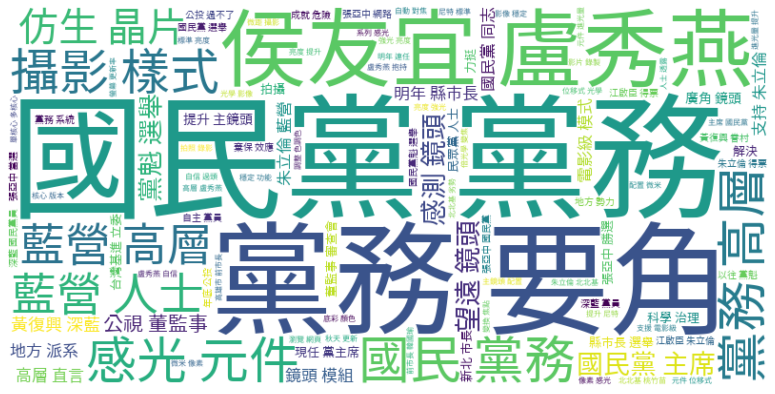

In [181]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('陳柏惟','3Q','罷免'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

從正面情緒的句子中，「政黨」的相關詞彙討論度非常高，如：「國民黨」、「黨務」。另外，也有少部分在討論一些政治人物，如：「盧秀燕」、「侯友宜」等等。

## 4.3 負面詞彙探索

從上圖中可以發現 9/24-9/27 的情緒特別低，因此我們把那天的負面句子挑出來看看裡面有什麼詞，根據上面的盒狀圖，我們選取情緒值小於0.5的句子。

In [182]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-09-24').date()
date2 = pd.to_datetime("2021-09-27").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

,artUrl,sentence,artDate,artCat,sentimentValue
558,https://www.ptt.cc/bbs/HatePolitics/M.16324467...,朱接受廣播節目專訪時甚至指出，他跳出來參選，是與韓國瑜共同討論後的決定，由他出馬參選黨魁，比...,2021-09-24,HatePolitics,5.126874e-06
559,https://www.ptt.cc/bbs/HatePolitics/M.16324467...,國民黨主席候選人江啟臣昨日受訪表示，在四位候選人中，他與前高雄市長韓國瑜最有革命情感，韓當年...,2021-09-24,HatePolitics,1.299581e-01
563,https://www.ptt.cc/bbs/HatePolitics/M.16324567...,明天過後，國民黨也該反擊復仇了，讓我們高唱塔綠班之歌，把躲在幕後搬弄是非的側翼網軍徹底剷除，...,2021-09-24,HatePolitics,1.210413e-02
564,https://www.ptt.cc/bbs/HatePolitics/M.16324567...,還台灣乾淨的政治風氣今年可能來不及，下次應該編列預算繳國民黨黨費，臥底要臥成真才能灌開大門走...,2021-09-24,HatePolitics,6.259659e-11
565,https://www.ptt.cc/bbs/HatePolitics/M.16324577...,我剛剛吃飯內用看電視，竟然看到朱立倫競選廣告,2021-09-24,HatePolitics,3.545678e-03
566,https://www.ptt.cc/bbs/HatePolitics/M.16324577...,原來國民黨主席選舉，只有四十萬人有投票權竟然用的上電視廣告，真讓我開了眼界，沒印像以前有看過,2021-09-24,HatePolitics,4.520893e-04
567,https://www.ptt.cc/bbs/HatePolitics/M.16324577...,我本來以為他躺著就會贏，現在看到他沒在躺了明天看結果你這句說得很好，人民對政府政客不滿就應該...,2021-09-24,HatePolitics,4.265340e-05
568,https://www.ptt.cc/bbs/HatePolitics/M.16324801...,個人感覺這位黨主席參選人似乎搞不清楚在野黨能做的是甚麼事整個把焦點放在與對岸談和平協議之類的...,2021-09-24,HatePolitics,1.734240e-08
752,https://www.ptt.cc/bbs/HatePolitics/M.16327144...,江啟臣上午與立委林奕華台北市議員張斯綱高雄市前局長鄭照新等人與前立委顏寬恒一起擔任刪行動義工掃街,2021-09-27,HatePolitics,4.296568e-01
754,https://www.ptt.cc/bbs/HatePolitics/M.16327144...,在同一時間，陳柏惟選擇在烏日區三民街市場爭取選民支持，對於江啟臣選輸黨主席的次日就來他的選區...,2021-09-27,HatePolitics,9.365931e-05


In [183]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
negative_words = negative_words[['artUrl','sentimentValue','word']]

In [184]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

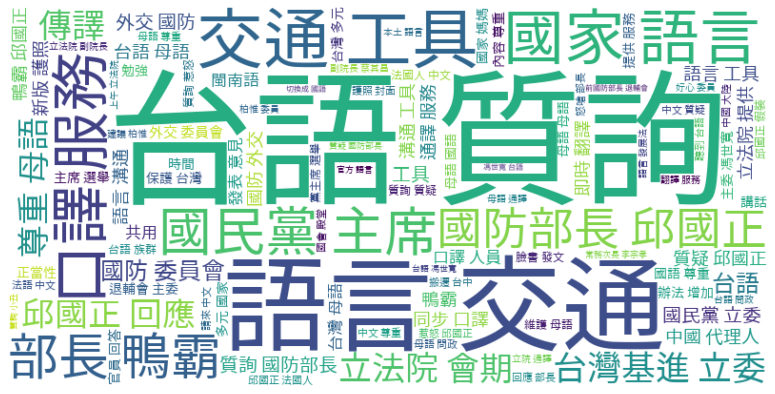

In [185]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('陳柏惟','3Q','罷免'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

從上面負面詞彙文字雲，我們大概可以看出網友對於「陳柏質詢國防部長堅持講台語」，並要求口譯人員再將他的詢答翻成台語此事件造成大批網友撻伐，因此從上圖可以看到許多此事件的相關詞彙如：「台語」、「質詢」、「語言」等等。

## 4.4 CKIP小結論

1. 由PPT「八卦版」及「政黑板」中爬出有關「3Q罷免案」的文章，希望藉由以上的分析了解該事件有什麼主要的關係人及牽扯到哪些相關的組織，因此透過上面的分析我們得到的重點如下：
 - 涉及到的人名：
   - 陳柏惟、顏家、朱立倫、韓國瑜皆是討論度相當高的人物，其餘包括林旭佐、顏寬恆也經常一起被提及
 - 涉及到的組織：
   - 最常被提到的組織政黨無非是民進黨及國民黨，而立法院及基進黨由於與本次事件具有高度相關，因此也會一起被討論  
   
2. PPT上「八卦版」及「政黑板」的情緒分布趨勢如何，正面和負面的文章主要的討論焦點是什麼?
 - 由於主題是有關於罷免，因此兩個版分析出來的情緒值大多低於0.5，也就是幾乎都是負面情緒，只有少數幾天的情緒是屬於正面的
 - 正面貼文：
   - 相關的關鍵字有：國民黨、黨務、要角
   - 大多都在討論有關政黨、相關黨員及政治人物
 - 負面貼文：
   - 相關的關鍵字有：台語、質詢、語言、工具、交通
   - 多因為「陳柏質詢國防部長」事件，由於陳柏惟堅持講台語質詢國防部長，又要求口譯人員將他的詢答翻成台語，此事件造成大批網友撻伐。

# 5. TF-IDF + Ngram 

重新把 fighting 資料匯入data中，以利後續 TF-IDF與Ngram分析

In [8]:
data = data.explode('word')

In [187]:
data = data.copy()
data['word'] = data.sentence.apply(getToken)

In [188]:
# 將word欄位展開 (word 欄位中的每一個 element 為一個 list 其中包含斷完詞且刪除停用字後的結果)
data = data.explode('word')

In [11]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,來源
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,王婉諭
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,內容


In [12]:
#計算各詞彙在各文章 (同一篇文章) 中出現的次數
word_count = data.groupby(['artUrl','word']).size().reset_index(name='count')

In [13]:
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,加州,1
1,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,卒業,1
2,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,史上,1
3,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,州長,2
4,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,惹媽,1
...,...,...,...
345169,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,靜好,1
345170,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,面對,1
345171,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,首都,1
345172,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,黨性,1


## 5.1 TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
### 5.1.1 計算每篇文章的詞數

In [16]:
total_words = data.groupby(['artUrl'],as_index=False).size().reset_index(name='total')
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,14
1,https://www.ptt.cc/bbs/Gossiping/M.1631638429....,123
2,https://www.ptt.cc/bbs/Gossiping/M.1631679532....,8
3,https://www.ptt.cc/bbs/Gossiping/M.1631679680....,14
4,https://www.ptt.cc/bbs/Gossiping/M.1631688930....,210
...,...,...
7004,https://www.ptt.cc/bbs/HatePolitics/M.16350907...,170
7005,https://www.ptt.cc/bbs/HatePolitics/M.16350908...,69
7006,https://www.ptt.cc/bbs/HatePolitics/M.16350909...,49
7007,https://www.ptt.cc/bbs/HatePolitics/M.16350910...,16


### 5.1.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [28]:
water_words = word_count.merge(total_words,on = 'artUrl',how = 'left') # 對應 SQL中的　Left outer join 
water_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,加州,1,14
1,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,卒業,1,14
2,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,史上,1,14
3,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,州長,2,14
4,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,惹媽,1,14
...,...,...,...,...
345169,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,靜好,1,174
345170,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,面對,1,174
345171,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,首都,1,174
345172,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,黨性,1,174


### 5.1.3 計算 tf-idf 值

In [29]:
#計算tf
water_words_tf_idf = water_words.assign(tf = water_words.iloc[:,2]/water_words.iloc[:,3])

In [30]:
# 計算每個詞彙出現在幾篇文章中
idf_df = water_words.groupby(['word'],as_index=False).size().reset_index(name='size')
water_words_tf_idf = water_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [31]:
#計算idf (len(total_words)) 計算文章總數 (7009篇)
water_words_tf_idf = water_words_tf_idf.assign(idf = water_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10))) #對這個 column 做 apply 

water_words_tf_idf = water_words_tf_idf.drop(labels=['size'],axis=1) # axis 表示針對 column 

In [32]:
#計算tf*idf
water_words_tf_idf = water_words_tf_idf.assign(tf_idf = water_words_tf_idf.iloc[:,4]*water_words_tf_idf.iloc[:,5])

In [33]:
water_words_tf_idf

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,加州,1,14,0.071429,2.699528,0.192823
1,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,卒業,1,14,0.071429,3.146686,0.224763
2,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,史上,1,14,0.071429,2.314177,0.165298
3,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,州長,2,14,0.142857,2.891414,0.413059
4,https://www.ptt.cc/bbs/Gossiping/M.1631635847....,惹媽,1,14,0.071429,3.845656,0.274690
...,...,...,...,...,...,...,...
345169,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,靜好,1,174,0.005747,3.544626,0.020371
345170,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,面對,1,174,0.005747,1.301588,0.007480
345171,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,首都,1,174,0.005747,3.146686,0.018084
345172,https://www.ptt.cc/bbs/HatePolitics/M.16350911...,黨性,1,174,0.005747,3.067505,0.017629


In [34]:
# 選出每篇文章，tf-idf值最大的五個詞
group = water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [35]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/Gossiping/M.1631635847.A... 3     州長  0.413059
                                                   4     惹媽  0.274690
                                                   7    民主黨  0.240610
                                                   8    第二位  0.231685
                                                   1     卒業  0.224763
https://www.ptt.cc/bbs/Gossiping/M.1631638429.A... 89   苗可麗  0.156327
                                                   23    可麗  0.093796
                                                   56    攝苗  0.093796
                                                   112  龍劭華  0.093796
                                                   42    寄出  0.054773
https://www.ptt.cc/bbs/Gossiping/M.1631679532.A... 118   是夠  0.421067
                                                   115   加州  0.337441
                                                   119   深藍  0.258438
                                                   122   開票  0.233492
                                                   116   失敗  0.185965

#### 計算整個文集中較常 tf-idf 值高的字

In [36]:
# 從每篇文章挑選出tf-idf最大的十個詞
(water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size().reset_index(name='size')
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
17847,柏惟,248
24454,罷免,181
19158,民進黨,149
7239,同意,131
8603,國民黨,129
24150,綠班,127
19079,民主,121
1443,中國,114
7004,台語,102
31819,顏家,95


## 小結

以上的分析流程我們先計算每個文章中每個字詞的 TF-IDF ，再將每篇文章中前十大 TF-IDF 數值的字詞挑出，最後總結出整個文集中前十大的 TF-IDF 的字詞，由以上的結果可以明顯看出，該份文集所討論的核心議題為陳柏維的罷免案，且參雜在其中的關鍵角色有民進黨、國民黨以及顏家等等，因此 TF-IDF 可以協助我們快速地掌握一份文集的核心議題以及重要的文眼。

## 5.2 透過結巴斷詞與N-gram幫助建立字典
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
而我們主要利用N-gram尋找熱門詞的相關議題有哪些，最後做出共線圖。

### 5.2.1 Bigram

In [37]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row) # 先斷詞並且生成 list 
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] #去除停用字
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [38]:
qqq_bigram = MetaData.copy()
qqq_bigram["word"] = qqq_bigram.sentence.apply(bigram_getToken)

In [39]:
qqq_bigram = qqq_bigram.explode('word')
qqq_bigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,來源 王婉諭
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,王婉諭 內容
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,內容 打破


#### 統計最常出現的bigram組合

In [40]:
# 計算每個組合出現的次數
qqq_bigram_count = qqq_bigram.groupby(["word"],as_index=False).size().reset_index(name="size")

In [41]:
# 清除包含英文或數字的bigram組合
qqq_filter = list(qqq_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
qqq_bigram_count[qqq_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
169970,柏惟 罷免,952
64730,台灣 基進,778
241715,肇事 逃逸,753
220652,立委 柏惟,610
235197,罷免 投票,463
235127,罷免 成功,443
148692,政治 人物,420
68651,同意 罷免,383
84860,基進 立委,369
235537,罷免 柏惟,350


### 5.2.2 Trigram

In [42]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [43]:
qqq_trigram = MetaData.copy()
qqq_trigram["word"] = qqq_trigram.sentence.apply(trigram_getToken)
qqq_trigram = qqq_trigram.explode('word')
qqq_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,來源 王婉諭 內容
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,王婉諭 內容 打破
0,[轉錄]王婉諭時力聯立制修憲草案！,2021/09/15,00:04:08,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,ctx705f,HatePolitics,140,41,17,來源王婉諭內容打破兩黨格局重塑多元政治時代力量正式推出聯立制修憲草案自從解嚴之後台灣政壇的兩...,內容 打破 兩黨


#### 統計最常出現的trigram組合

In [44]:
# 計算每個組合出現的次數
qqq_trigram_count = qqq_trigram.groupby(["word"],as_index=False).size().reset_index(name='size')
# 清除包含英文或數字的trigram組合
qqq_filter = list(qqq_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
qqq_trigram_count[qqq_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
264012,立委 柏惟 罷免,365
101920,基進 立委 柏惟,335
75856,台灣 基進 立委,319
366313,附註 心得 想法,229
102193,基進 黨立委 柏惟,174
202774,柏惟 罷免 投票,154
202833,柏惟 罷免 案將,134
386282,黨立委 柏惟 罷免,109
75910,台灣 基進 黨立委,99
284813,罷免 案將 投票,83


由以上的 2 gram 以及 3 gram 的結果，我們可以明顯看出本次文本的重點都圍繞在陳柏維罷免投票案上。  
以及我們也可以猜測，陳柏維過去的肇事逃逸案件對於本次的罷免案有著滿大的負面衝擊，原因在於本次的肇事逃逸出現的頻率明顯居於第二。

## 5.3 建立Ngram預測模型

In [45]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [46]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [47]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [262]:
text = '投票'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 陳柏惟, probability: 0.0293
next word: 倒數, probability: 0.0293
next word: 罷免, probability: 0.0263
next word: 同意, probability: 0.0243
next word: 人數, probability: 0.0214


與投票較相關的詞有「陳柏惟」、「倒數」、「罷免」、「同意」、「人數」。  
因此我們推論多半在討論投票時，大多數網友都在討論如何罷免掉陳柏惟，如：投票罷免人數要有多少才過。

In [263]:
text = '柏惟'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 加油, probability: 0.0543
next word: 守住, probability: 0.0351
next word: 委員, probability: 0.0224
next word: 辛苦, probability: 0.0192
next word: 呈現, probability: 0.016


與柏惟較相關的詞有「加油」、「守住」、「委員」、「辛苦」、「呈現」。  
因此我們推論多半在討論柏惟時，大多數網友都在鼓勵陳柏惟，希望他不要被罷免。

## 5.4 Bigram 視覺化

In [48]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
trigramfdist = FreqDist()
def bigram_getToken_dict(row,n=2,dist=bigramfdist):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    dist.update(ngrams(seg_list, n))
    seg_list2 = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [49]:
qqq_bigram2 = MetaData.copy()
qqq_bigram2["word"] = qqq_bigram2.sentence.apply(lambda x: bigram_getToken_dict(row = x,n=2,dist=bigramfdist))

In [50]:
qqq_bigram2 = qqq_bigram2.explode('word')

In [51]:
bigramfdist.most_common(5)

[(('柏惟', '罷免'), 952),
 (('台灣', '基進'), 778),
 (('肇事', '逃逸'), 753),
 (('立委', '柏惟'), 610),
 (('罷免', '投票'), 463)]

### 5.4.1 Create network plot

In [52]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d1 = {k:v for k,v in bigramfdist.most_common(30)}

In [53]:
G1 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d1][0].items():
    G1.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights1 = [w[2]['weight']*0.03 for w in  G1.edges(data=True)]

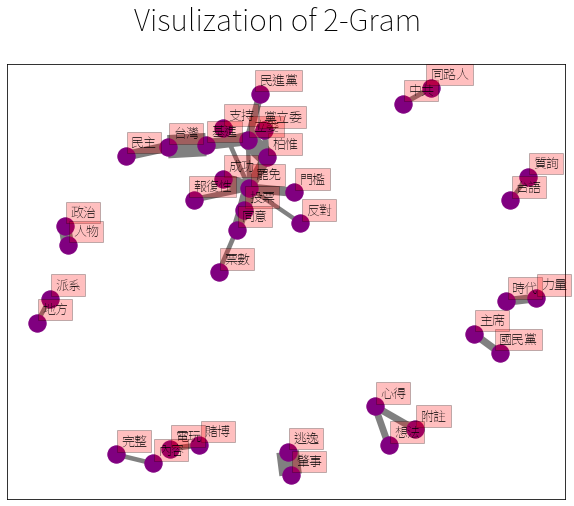

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G1, k=2)

# networks
nx.draw_networkx(G1, pos,
                 font_size=16,
                 width=weights1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram', fontsize=30)    
plt.show()

我們發現對於 N = 2 時所視覺化的圖表有解釋性，針對 bigram 視覺化我們可以發現議題的核心以陳柏維辦免案開始擴散，其中包含基進黨、國民黨、民進黨等關鍵角色，在圖的下方可以看見賭博、電玩、肇事逃逸等字樣，說明本次的罷免案中，陳柏惟過去的所做所為成為在 ptt 版上被放大的討論焦點，最後我們可以看見中共同路人、時代力量等字詞，說明這兩個分枝同樣也是本次罷免案的討論一環。總得來說由 Bigram visulization ，我們可以把本次陳柏惟罷免案的關鍵人物以及事件都呈現其中，並且透過節點之間的連結以及粗細來視覺化出不同節點之間的關聯性。

# 6 文件分類

## 6.1文字前處理
+ 6.1.1 斷句
+ 6.1.2 斷詞（刪掉次數太少的、標點符號、停用字）
+ 6.1.3 算出情緒分數，將正負面文章分類
+ 6.1.4 將情緒標籤加回原本的資料集  

### 6.1.1 斷句
利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [4]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [5]:
# 篩選需要的欄位
fighting['content'] = fighting['artTitle'] + fighting['sentence']
fighting = fighting.dropna() #去掉空白欄位
data = fighting[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

C:\Users\Hao\AppData\Local\Temp/ipykernel_18740/2671001194.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開


,sentence,artUrl,document
0,[轉錄]王婉諭時力聯立制修憲草案！,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,0
0,1.轉錄網址︰,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,1
0,https://www.facebook.com/wanyu.claire/posts/41...,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,2


In [6]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 128754


### 6.1.2 斷詞
+ 進行斷詞
    + 去除標點符號
    + 去除stopwords
    + 篩選出現太少次的字

In [23]:
def load_stop_words(path):
    with open(path,encoding="utf-8") as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文 
    sent = re.sub('(http|https)://.*', '', sent)
    sent = re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', sent)
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [24]:
# 這裡會跑比較久
stop_path = 'dict/stop_words.txt'
user_path = 'dict/user_dict.txt'

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
0,[轉錄]王婉諭時力聯立制修憲草案！,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,0,轉錄 王婉諭 時力 聯立制 修憲 草案
0,1.轉錄網址︰,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,1,轉錄
0,https://www.facebook.com/wanyu.claire/posts/41...,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,2,
0,2.轉錄來源︰,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,3,轉錄 來源
0,王婉諭,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,4,王婉諭


In [25]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

C:\Users\Hao\AppData\Local\Temp/ipykernel_18740/2608552995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list


,document,word
0,0,轉錄
1,0,王婉諭
2,0,時力
3,0,聯立制
4,0,修憲


In [26]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 80467


### 6.1.3 算出情緒分數，將正負面文章分類
+ 待會分類任務要用的
+ 用 week4 的 liwc 字典
+ 讀入liwc的字典，轉換成dataframe

In [27]:
# 參考 week4 code
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/ntu/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split("\n"),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

In [28]:
# 獲得情緒字典
data_liwc = load_senti() 
data_liwc.head(5)

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative


In [30]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,2,3.0,0.0,neg
1,6,1.0,0.0,neg
2,7,0.0,1.0,pos
3,8,0.0,1.0,pos
4,9,1.0,0.0,neg


### 6.1.4 將情緒標籤加回原本的資料集
+ 把情緒標籤加回去
+ 如果該篇文章沒有情緒字，就算是中性的文章

將剛剛得到的`senti_count`資料框和一開始的`data`資料集合併，得到每句話的情緒。

In [31]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,[轉錄]王婉諭時力聯立制修憲草案！,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,0,轉錄 王婉諭 時力 聯立制 修憲 草案,neu
1,1.轉錄網址︰,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,1,轉錄,neu
2,https://www.facebook.com/wanyu.claire/posts/41...,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,2,,neg
3,2.轉錄來源︰,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,3,轉錄 來源,neu
4,王婉諭,https://www.ptt.cc/bbs/HatePolitics/M.16316642...,4,王婉諭,neu


### 6.2 資料集基本檢視

In [32]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 6993
total sentences: 128754


In [33]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
108928,pos,陳柏惟,2798
102309,pos,罷免,2620
100552,pos,知道,1549
101115,pos,立委,1327
87054,pos,台灣,1257


In [34]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
11922,neg,投票,368
24135,neg,賭博,370
664,neg,不到,378
12855,neg,支持,379
22501,neg,表示,380


從結果中我們發現在正負面情緒的資料中，「投票」、「賭博」、「支持」是熱門議題，在兩邊文本中都有出現。而賭博一詞與前面分析結果相同，揭示網友熱門的討論議題。

In [35]:
book1 = book1.drop(index=[0])

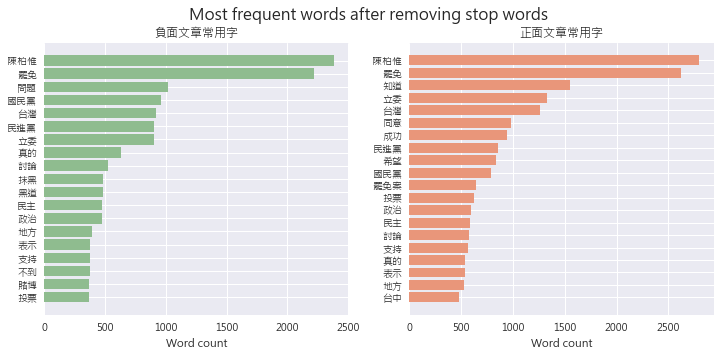

In [74]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

## 6.3 將資料切成訓練集與測試集
### 6.3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [37]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [38]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    48.705283
neg    33.379157
pos    17.915560
Name: label, dtype: float64

train percentage :
neu    48.704606
neg    33.379564
pos    17.915830
Name: label, dtype: float64

test percentage :
neu    48.706863
neg    33.378207
pos    17.914930
Name: label, dtype: float64


## 6.4 將文章轉為 DTM
+ 6.4.1 套入正式資料集訓練

### 6.4.1 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [39]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [40]:
corpus = dtf_train["clean_txt"]

+ 過濾詞頻比較

In [41]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 90127 words: 10000 (10000)
with term cut off: posts 90127 words: 4952 (4952)


<90127x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 298005 stored elements in Compressed Sparse Row format>

In [43]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [44]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.91      0.87     12893
         neu       0.93      0.89      0.91     18814
         pos       0.96      0.91      0.94      6920

    accuracy                           0.90     38627
   macro avg       0.91      0.91      0.91     38627
weighted avg       0.90      0.90      0.90     38627



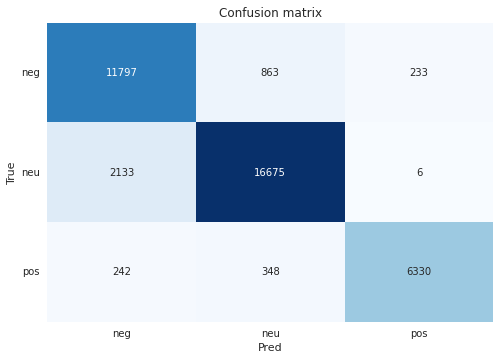

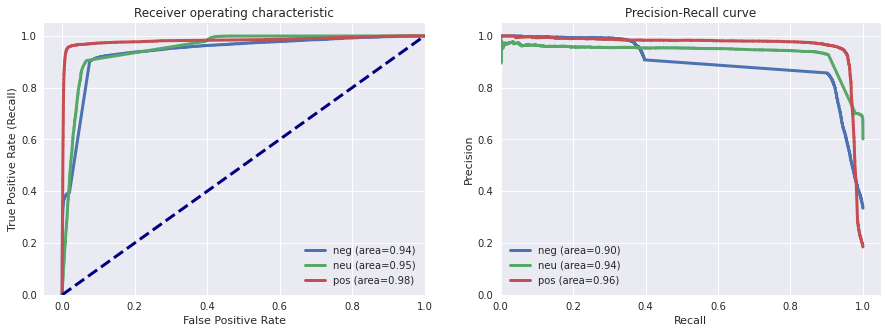

In [45]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [46]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.88
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.80      0.90      0.85     12893
         neu       0.92      0.86      0.89     18814
         pos       0.96      0.91      0.93      6920

    accuracy                           0.88     38627
   macro avg       0.89      0.89      0.89     38627
weighted avg       0.89      0.88      0.88     38627



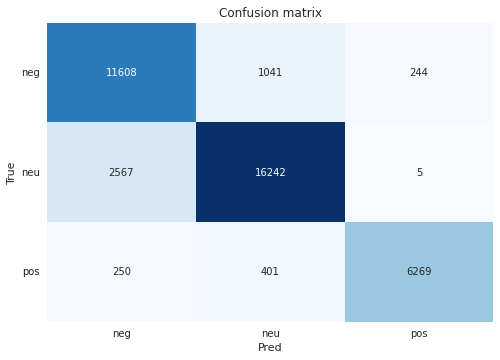

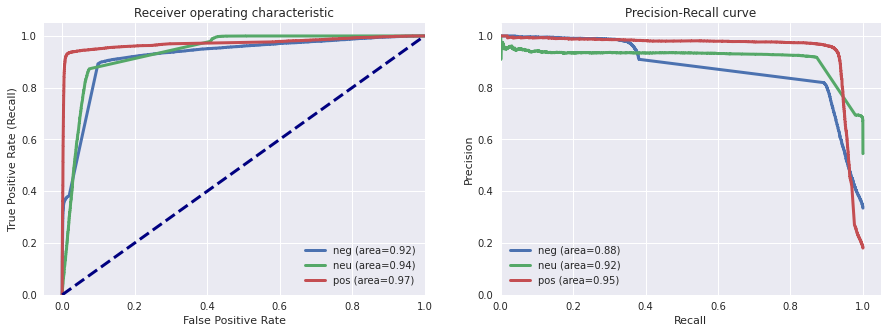

In [47]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 6.4.3 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [48]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [49]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別(正面、中性、負面情緒)的預測都視作為一個二元分類，以下比較上面各模型的分類效果

### step 1 定義 vectorizer

In [50]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

### step 2 定義 classifier

In [51]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [52]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [53]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 6.5 比較不同模型和資料組合的訓練結果

### 6.5.1 Model Building : logistic regression
logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)
+ [參考: Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

model type: CV + logistic regression


C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time costing: 3.6461710929870605
Accuracy: 0.9
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.91      0.87     12893
         neu       0.93      0.89      0.91     18814
         pos       0.96      0.91      0.94      6920

    accuracy                           0.90     38627
   macro avg       0.91      0.91      0.91     38627
weighted avg       0.90      0.90      0.90     38627



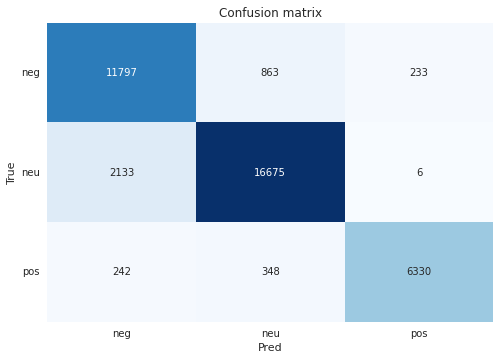

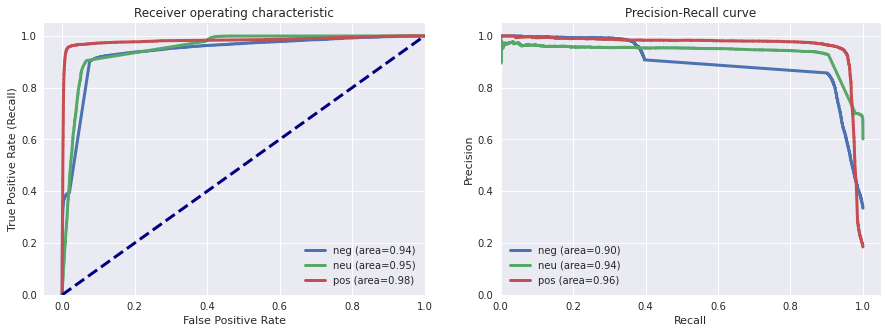

In [54]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression


C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time costing: 3.538400411605835
Accuracy: 0.88
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.83      0.89      0.86     12893
         neu       0.90      0.89      0.89     18814
         pos       0.97      0.85      0.91      6920

    accuracy                           0.88     38627
   macro avg       0.90      0.88      0.89     38627
weighted avg       0.89      0.88      0.88     38627



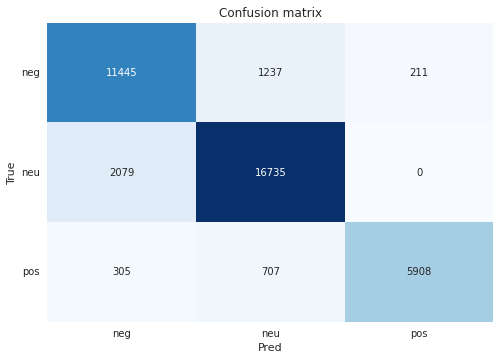

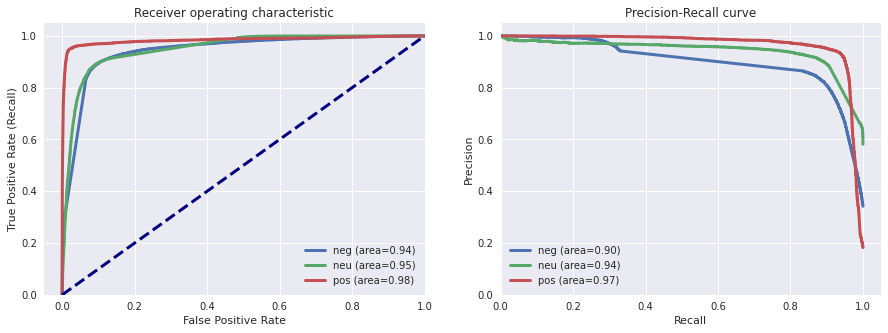

In [55]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 6.5.2 Model Building : SVC

model type: CV + SVC
time costing: 2691.4551599025726
Accuracy: 0.85
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.78      0.83      0.80     12893
         neu       0.87      0.84      0.86     18814
         pos       0.93      0.90      0.91      6920

    accuracy                           0.85     38627
   macro avg       0.86      0.86      0.86     38627
weighted avg       0.85      0.85      0.85     38627



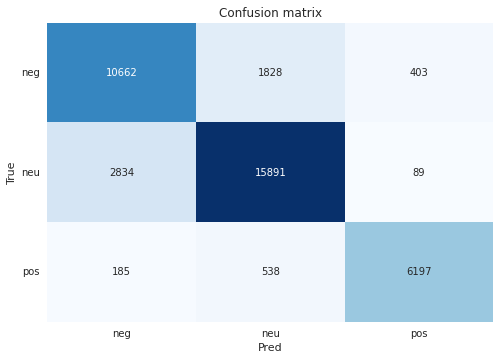

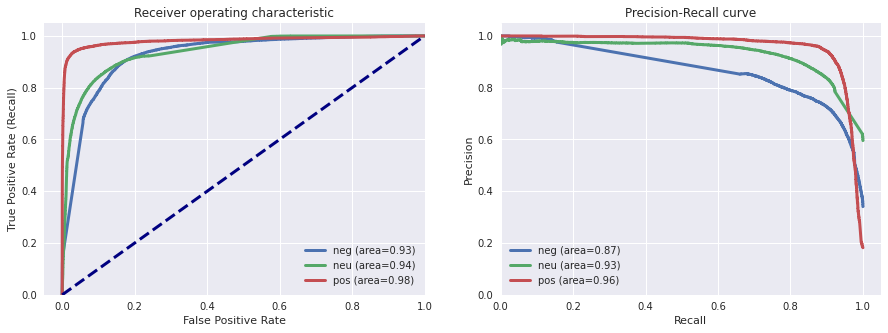

In [56]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 3108.6469445228577
Accuracy: 0.91
Auc: 0.97
Detail:
              precision    recall  f1-score   support

         neg       0.88      0.89      0.89     12893
         neu       0.91      0.92      0.92     18814
         pos       0.97      0.88      0.92      6920

    accuracy                           0.91     38627
   macro avg       0.92      0.90      0.91     38627
weighted avg       0.91      0.91      0.91     38627



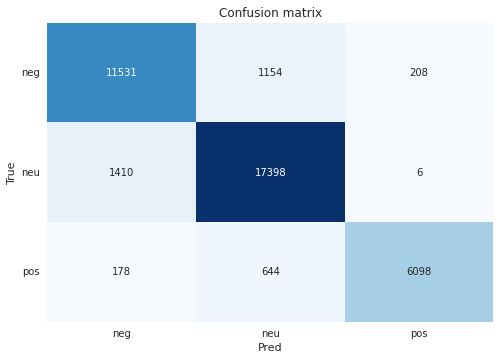

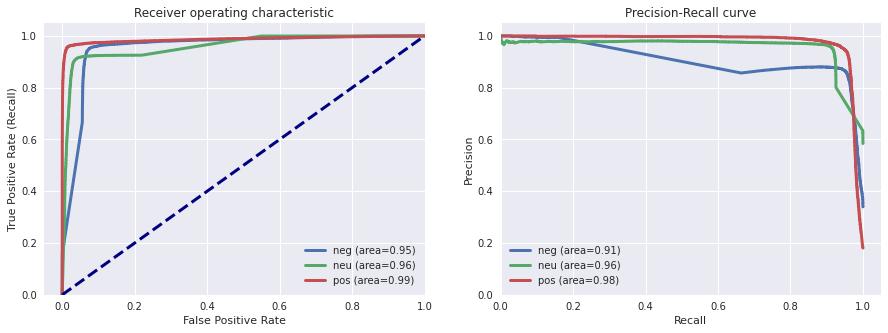

In [57]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc_all

### 6.5.3 Model Building : RandomForest

model type: CV + RandomForest
time costing: 137.56334519386292
Accuracy: 0.85
Auc: 0.93
Detail:
              precision    recall  f1-score   support

         neg       0.81      0.80      0.80     12893
         neu       0.84      0.88      0.86     18814
         pos       0.94      0.84      0.88      6920

    accuracy                           0.85     38627
   macro avg       0.86      0.84      0.85     38627
weighted avg       0.85      0.85      0.85     38627



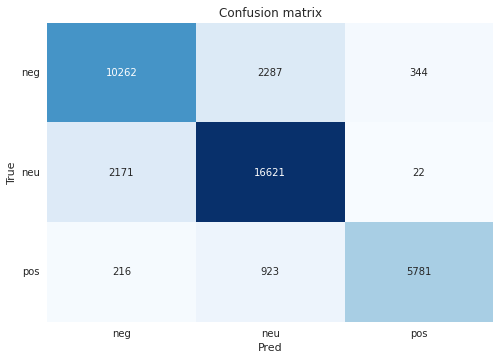

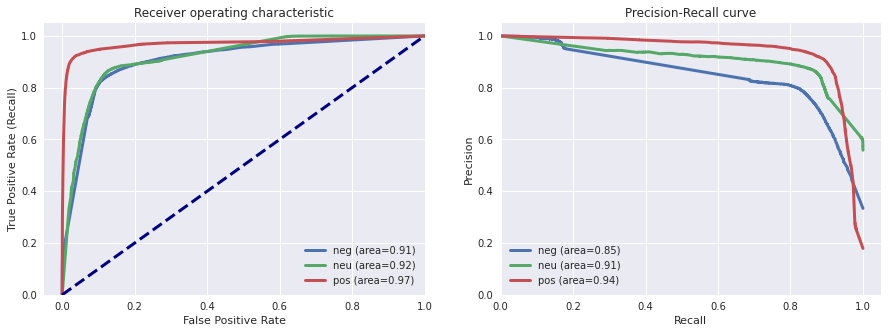

In [58]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 144.9319829940796
Accuracy: 0.85
Auc: 0.94
Detail:
              precision    recall  f1-score   support

         neg       0.80      0.81      0.81     12893
         neu       0.85      0.88      0.86     18814
         pos       0.94      0.85      0.90      6920

    accuracy                           0.85     38627
   macro avg       0.87      0.85      0.86     38627
weighted avg       0.85      0.85      0.85     38627



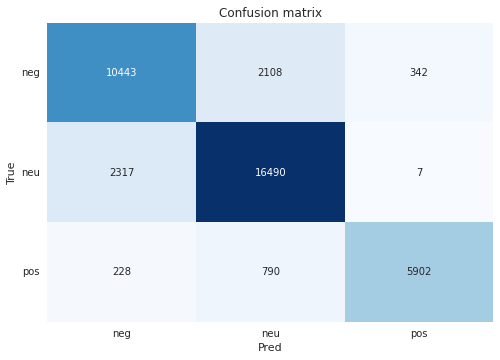

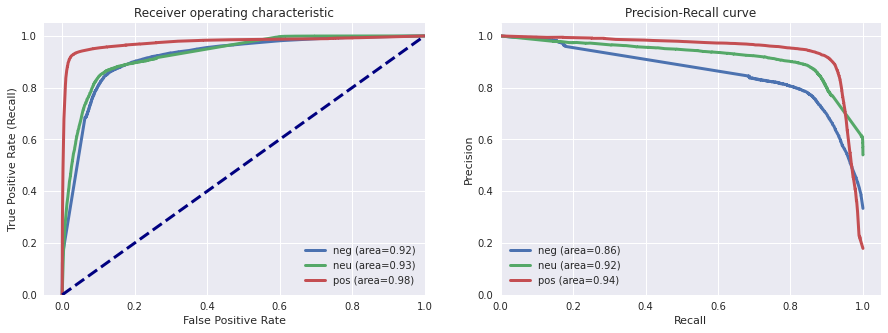

In [59]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 6.5.4 預測結果探索

查看模型預測結果

In [60]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
3,TF-IDF + SVC,0.906801,0.967005
0,CV + logistic regression,0.900976,0.958425
1,TF-IDF + logistic regression,0.882492,0.958876
5,TF-IDF + RandomForest,0.850053,0.940791
2,CV + SVC,0.847853,0.949236
4,CV + RandomForest,0.845626,0.931405


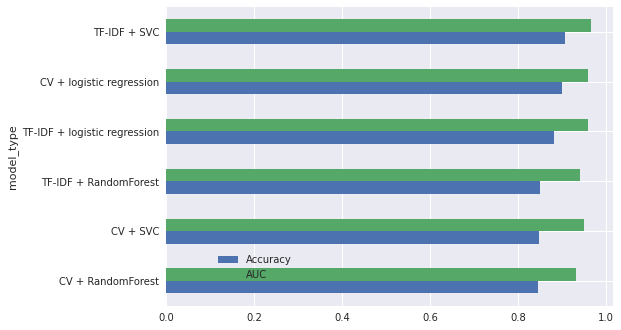

In [61]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

可以看到效果最好得組合是tf-idf，加上隨機森林的模型

### 6.5.5 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 logistic regression + cv tokenizer 為例

In [71]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [72]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

C:\ProgramData\Anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,neg,neu,pos
一一,0.207213,-0.121056,-1.871234
一上,-0.694819,-0.913730,-0.363769
一下,-0.845778,-1.125730,-0.473216
一下子,-0.664586,-0.400801,-0.891798
一中,-0.454218,0.130544,-0.496389


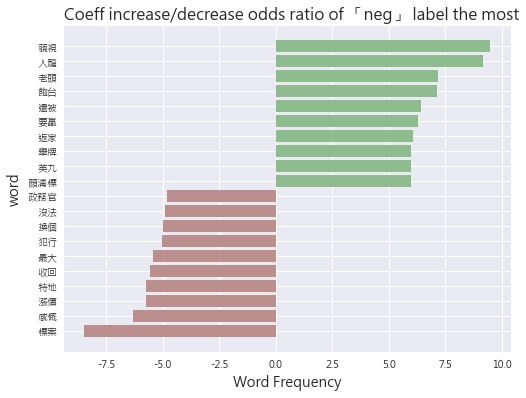

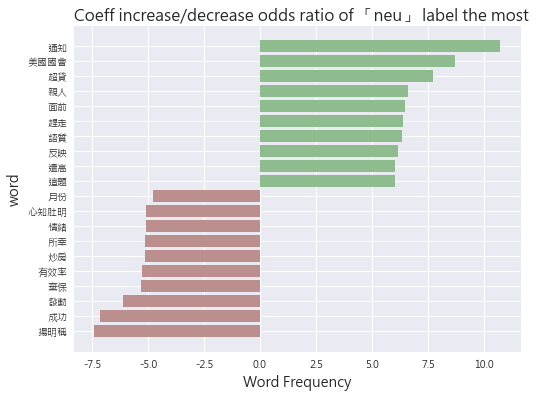

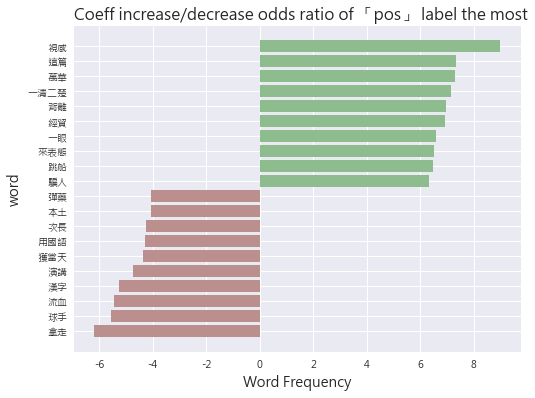

In [73]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

### 看一下含特定關鍵字的句子

In [65]:
keyword_list = ['罷免','黑道','誠信'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

,document,sentence,artUrl,label
147,147,[討論]加州州長罷免失敗這笑話一般的罷免結果可想而知就是個笑話：,https://www.ptt.cc/bbs/HatePolitics/M.16316779...,neg
173,173,罷免了！,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,neu
210,210,罷免了高雄市長，張亞中「能比他更高明」嗎？,https://www.ptt.cc/bbs/HatePolitics/M.16316790...,neu
259,259,[討論]建議把3Q留在立法院當提款機王浩宇真的被罷免了,https://www.ptt.cc/bbs/HatePolitics/M.16316838...,neu
269,269,[討論]TVBS台中立委陳柏惟罷免案民調(9/6-10)有人發起罷免XXX的連署，請問您知不...,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,neu
273,273,請問您會不會參與罷免XXX的連署？,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,neu
280,280,如果罷免XXX的提案通過，舉行罷免的投票，不論您同不同意罷免，請問您會不會去投票？,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,pos
289,289,如果舉行罷免XXX的投票，假如明天就是投票日，請問您會投同意罷免還是會投不同意罷免,https://www.ptt.cc/bbs/HatePolitics/M.16316868...,pos
359,359,Re:[討論]TVBS台中立委陳柏惟罷免案民調(9/6-10)我猜啦,https://www.ptt.cc/bbs/HatePolitics/M.16316882...,neu
361,361,罷免投票日是在10/23,https://www.ptt.cc/bbs/HatePolitics/M.16316882...,neu


### 6.5.6 查看分類錯誤的句子

In [66]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 1018
neg label predicted wrong: 2450
neu label predicted wrong: 2324


看一下都是什麼樣的句子分錯

In [67]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
103591,間七時卅分參與挺陳柏惟座談會，包括小英之友會總會長李茂盛、民進黨立法院副院長蔡,https://www.ptt.cc/bbs/Gossiping/M.1634397744....,pos,neu
30796,最好笑的是某些支持罷免的人,https://www.ptt.cc/bbs/HatePolitics/M.16341022...,pos,neu
113167,吳音寧表示，」到現在，我猶記得2020年的選舉，台中第二選區的鄉親，給了全台灣一個最大的驚喜。,https://www.ptt.cc/bbs/Gossiping/M.1634814849....,pos,neu
122881,有人應該會自動滾下台,https://www.ptt.cc/bbs/Gossiping/M.1634996081....,pos,neu
23946,有正視天然氣的發電成本跟外部成本(如興建接受站)的問題嗎,https://www.ptt.cc/bbs/HatePolitics/M.16337971...,pos,neg


In [68]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
72800,好好一個上班的女店員被神經病挖眼搞成這樣。,https://www.ptt.cc/bbs/Gossiping/M.1633323430....,neg,neu
25898,結果現實是他們今天不要說吃肉光是吃飽都是奢望，對金家舔菊姿勢不對都可能被犬決掉,https://www.ptt.cc/bbs/HatePolitics/M.16339169...,neg,neu
104597,拜託真的不用再恐嚇人民、唱衰台灣，面對惡霸侵犯，保護自己沒有錯。,https://www.ptt.cc/bbs/Gossiping/M.1634444588....,neg,pos
28938,路並進追殺陳柏惟。,https://www.ptt.cc/bbs/HatePolitics/M.16340368...,neg,neu
79760,或是探討臺灣法律怎麼如此悲哀,https://www.ptt.cc/bbs/Gossiping/M.1633550097....,neg,pos


In [69]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
42642,傳聞中他參選時，旗幟、傳單與帽子都是紅底，因而給稱為紅派。,https://www.ptt.cc/bbs/HatePolitics/M.16348811...,neu,neg
11910,就是有料,https://www.ptt.cc/bbs/HatePolitics/M.16333643...,neu,neg
104550,黃國書「線民」風暴將退政壇,https://www.ptt.cc/bbs/Gossiping/M.1634444556....,neu,neg
56038,等燕子2任當完,https://www.ptt.cc/bbs/HatePolitics/M.16350491...,neu,neg
105449,寧願勞保破產,https://www.ptt.cc/bbs/Gossiping/M.1634478601....,neu,neg


觀察模型分類效果，若一開始標註情況不佳，可以依據分類結果修改情緒字典

### 6.5.7 比較不同模型的ROC

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

KeyError: 'pos'

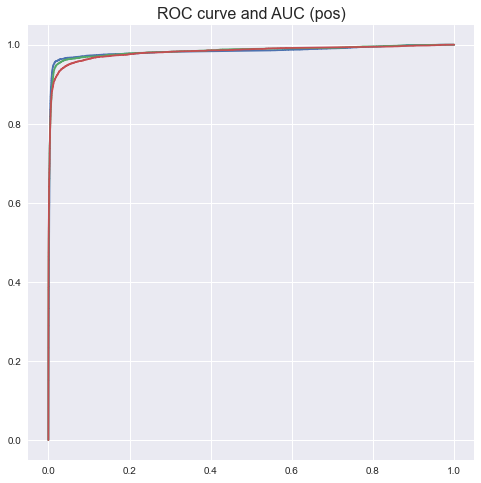

In [75]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到個模型在三種情緒的AUC指標都不會相差太多，對於AUC來說，整體而言 TF-IDF + SVC 的表現較好。若以準確率來看，CV + RandomForest 表現最好。